# Covid19 prediction

Covid19 prediction model



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

## Load and prepare the data

Supposed, accumulated data, daily data, flight data, tested data

In [2]:
data_path = 'train.csv'

data_train = pd.read_csv(data_path)

In [3]:
display(data_train.head())
display(data_train.describe())
display(data_train.info())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,25666.000000,25666.000000,25666.000000
mean,17825.500000,1063.526299,54.223408
std,10300.681447,7881.101295,626.629073
min,1.000000,0.000000,0.000000
25%,8913.250000,0.000000,0.000000
50%,17825.500000,1.000000,0.000000
75%,26737.750000,98.000000,1.000000
max,35650.000000,189033.000000,19899.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25666 entries, 0 to 25665
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              25666 non-null  int64  
 1   Province_State  10906 non-null  object 
 2   Country_Region  25666 non-null  object 
 3   Date            25666 non-null  object 
 4   ConfirmedCases  25666 non-null  float64
 5   Fatalities      25666 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


None

## Checking out the data

First, checking for US, Italy, Spain, South Korea.

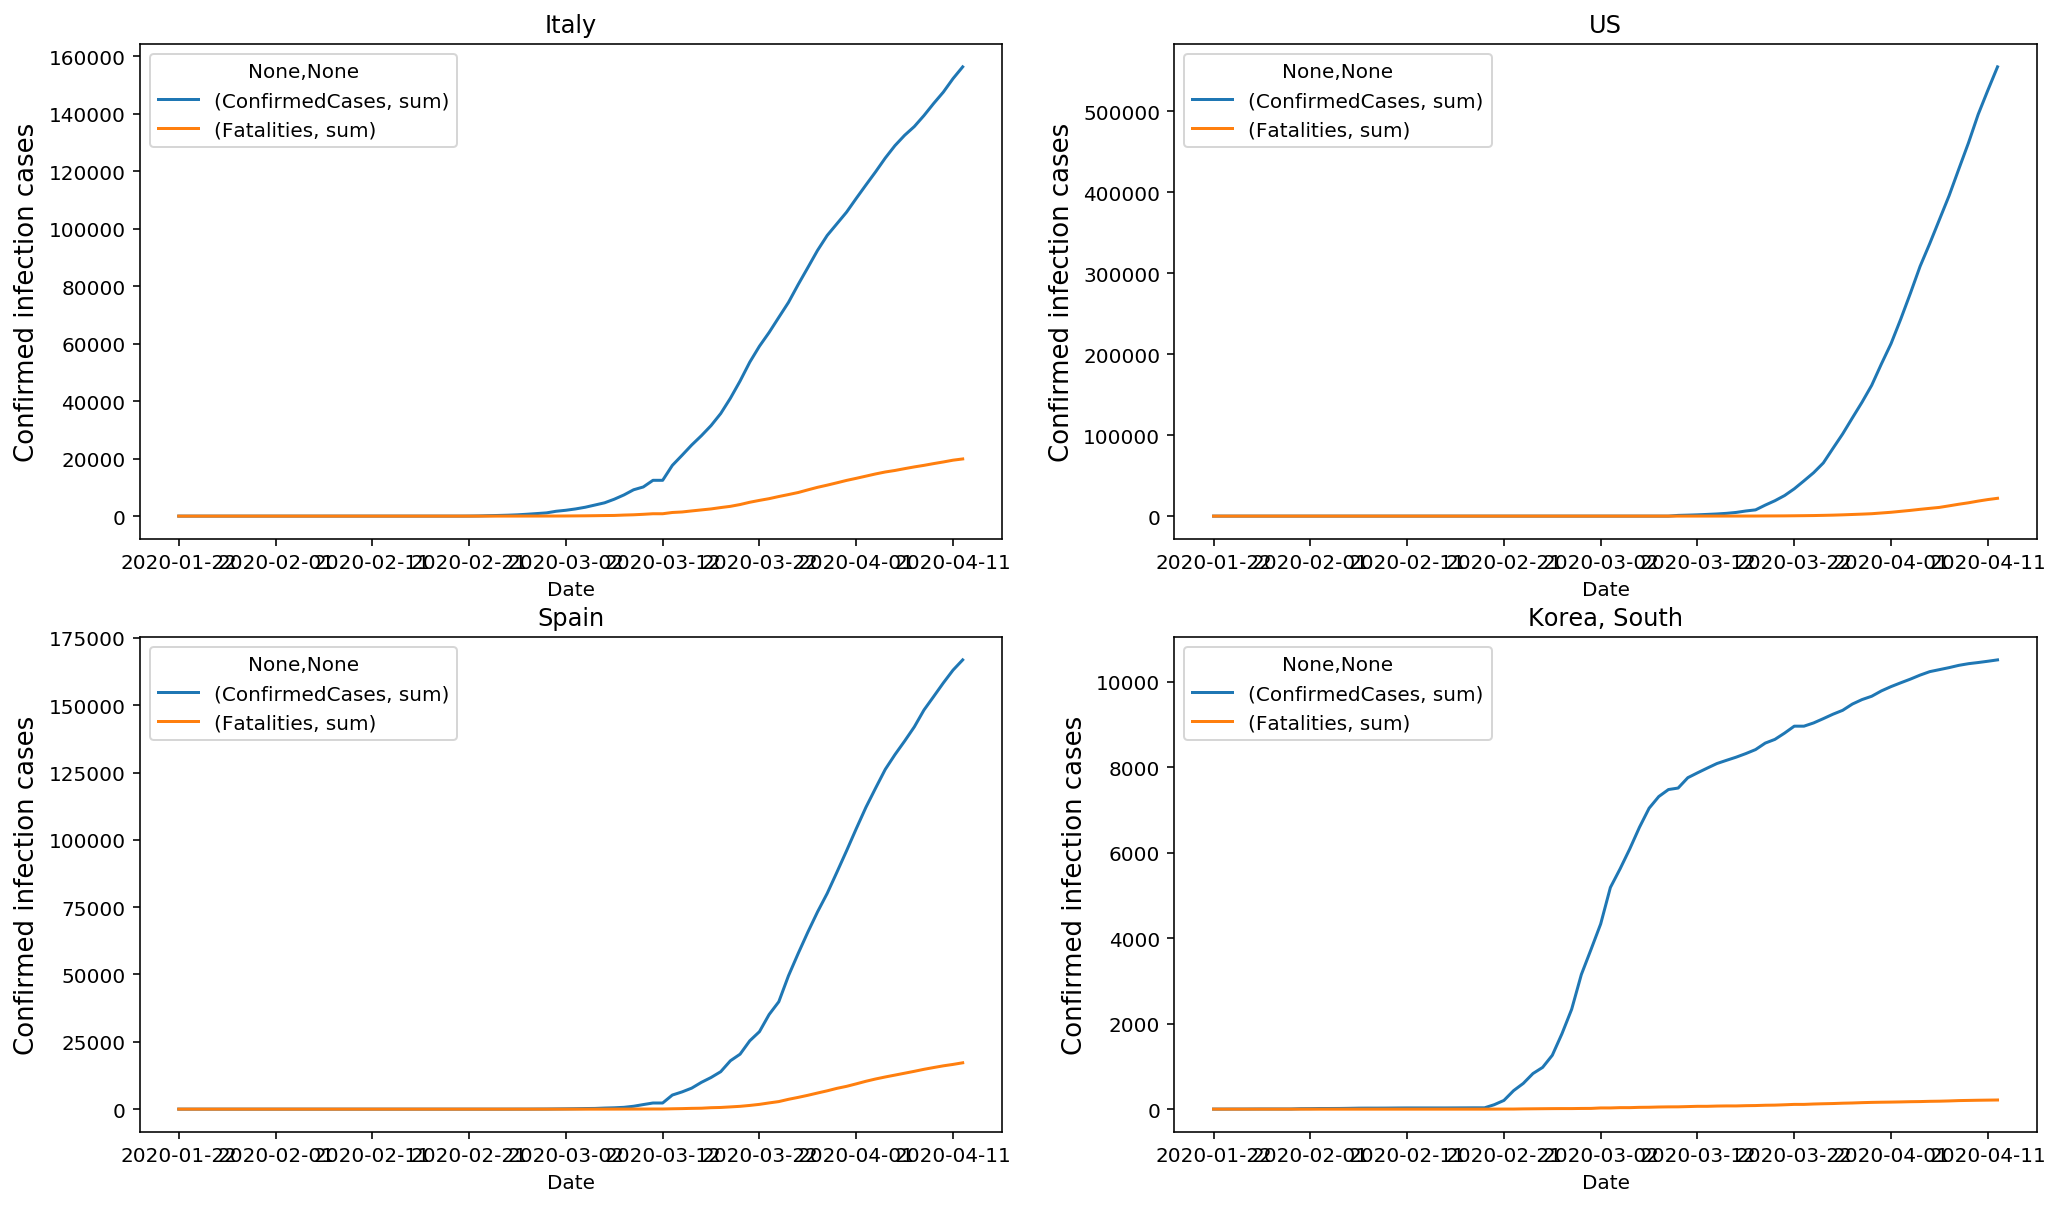

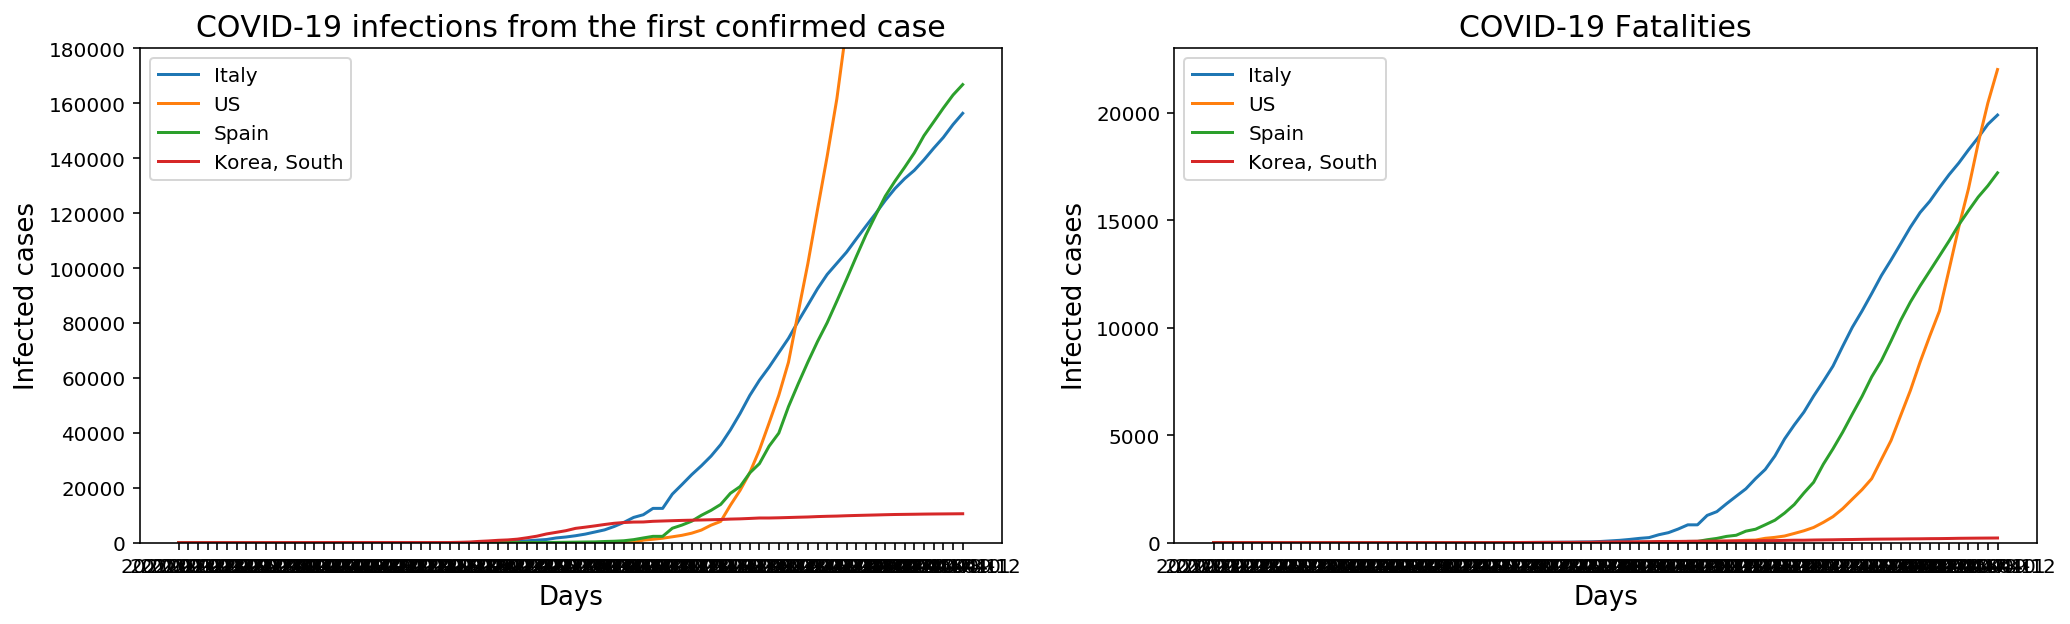

In [4]:
#data_train.plot(x='Date', y='ConfirmedCases')
confirmed_total_date_Italy = data_train[data_train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = data_train[data_train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

confirmed_total_date_US = data_train[data_train['Country_Region']=='US'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_US = data_train[data_train['Country_Region']=='US'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_US = confirmed_total_date_US.join(fatalities_total_date_US)

#plt.figure(figsize=(17,10))
plt.subplot(2, 2, 2)
total_date_US.plot(ax=plt.gca(), title='US')
plt.ylabel("Confirmed infection cases", size=13)

confirmed_total_date_Spain = data_train[data_train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = data_train[data_train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#plt.figure(figsize=(17,10))
plt.subplot(2, 2, 3)
total_date_Spain.plot(ax=plt.gca(), title='Spain')
plt.ylabel("Confirmed infection cases", size=13)

confirmed_total_date_Korea = data_train[data_train['Country_Region']=='Korea, South'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Korea = data_train[data_train['Country_Region']=='Korea, South'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Korea = confirmed_total_date_Korea.join(fatalities_total_date_Korea)

#plt.figure(figsize=(17,10))
plt.subplot(2, 2, 4)
total_date_Korea.plot(ax=plt.gca(), title='Korea, South')
plt.ylabel("Confirmed infection cases", size=13)

# Plots
plt.figure(figsize=(17,10))
plt.subplot(2, 2, 1)
plt.plot(confirmed_total_date_Italy)
plt.plot(confirmed_total_date_US)
plt.plot(confirmed_total_date_Spain)
plt.plot(confirmed_total_date_Korea)
plt.legend(["Italy", "US", "Spain", "Korea, South"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 180000)
#plt.show()

# Plots
#plt.figure(figsize=(12,6))
plt.subplot(2, 2, 2)
plt.plot(fatalities_total_date_Italy)
plt.plot(fatalities_total_date_US)
plt.plot(fatalities_total_date_Spain)
plt.plot(fatalities_total_date_Korea)
plt.legend(["Italy", "US", "Spain", "Korea, South"], loc='upper left')
plt.title("COVID-19 Fatalities", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 23000)
plt.show()

Daily values

In [5]:
def add_daily_measures(df):
    df.loc[0,'Daily Cases'] = df.loc[0,'ConfirmedCases']
    df.loc[0,'Daily Deaths'] = df.loc[0,'Fatalities']
    for i in range(1,len(df)):
        df.loc[i,'Daily Cases'] = df.loc[i,'ConfirmedCases'] - df.loc[i-1,'ConfirmedCases']
        df.loc[i,'Daily Deaths'] = df.loc[i,'Fatalities'] - df.loc[i-1,'Fatalities']
    #Make the first row as 0 because we don't know the previous value
    df.loc[0,'Daily Cases'] = 0
    df.loc[0,'Daily Deaths'] = 0
    return df

In [6]:
df_world = data_train.copy()
df_world = df_world.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_world = add_daily_measures(df_world)


C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


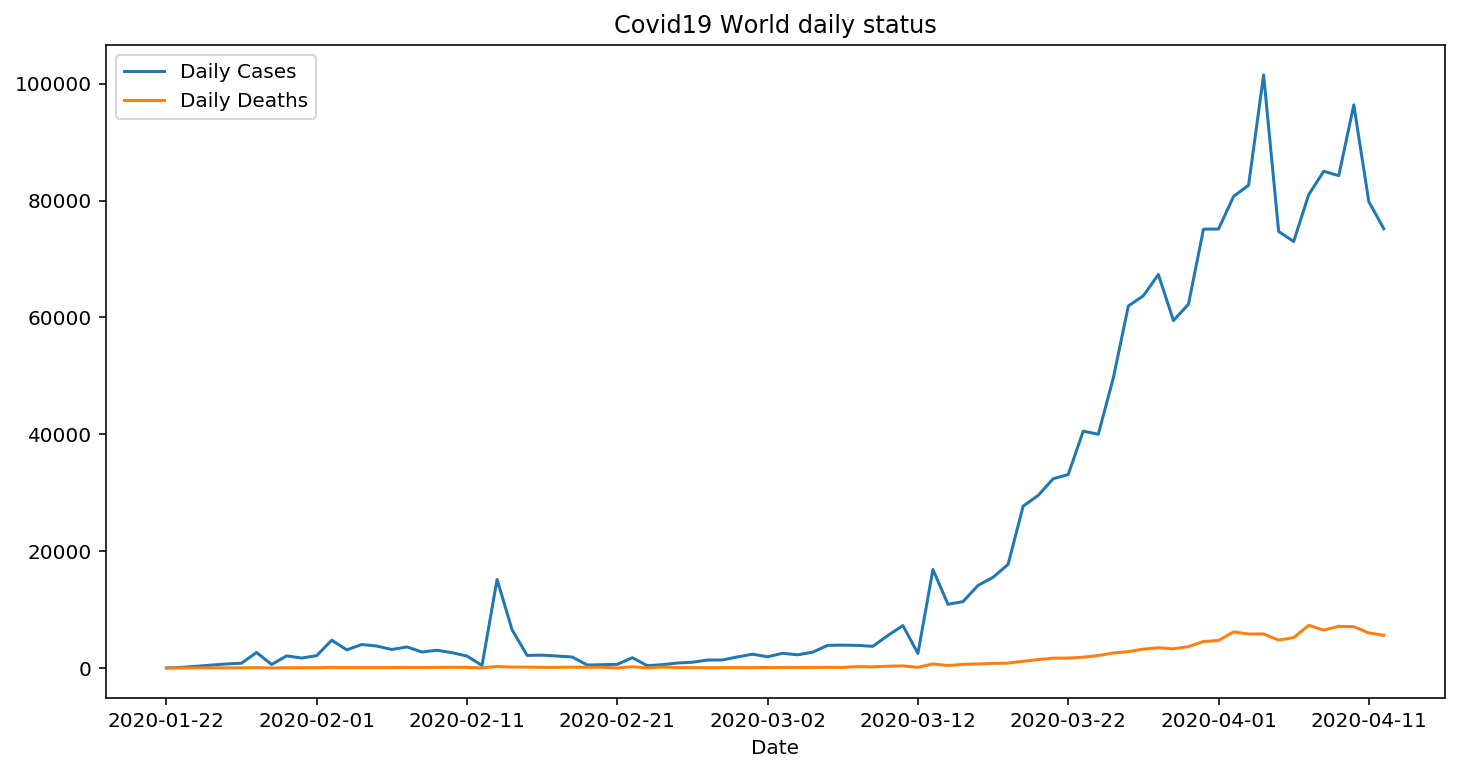

In [7]:
df_world.plot(title ='Covid19 World daily status', y=['Daily Cases','Daily Deaths'], x='Date', figsize=(12,6))

## Daily status

Four countries : US, Italy, Spain, South Korea

C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


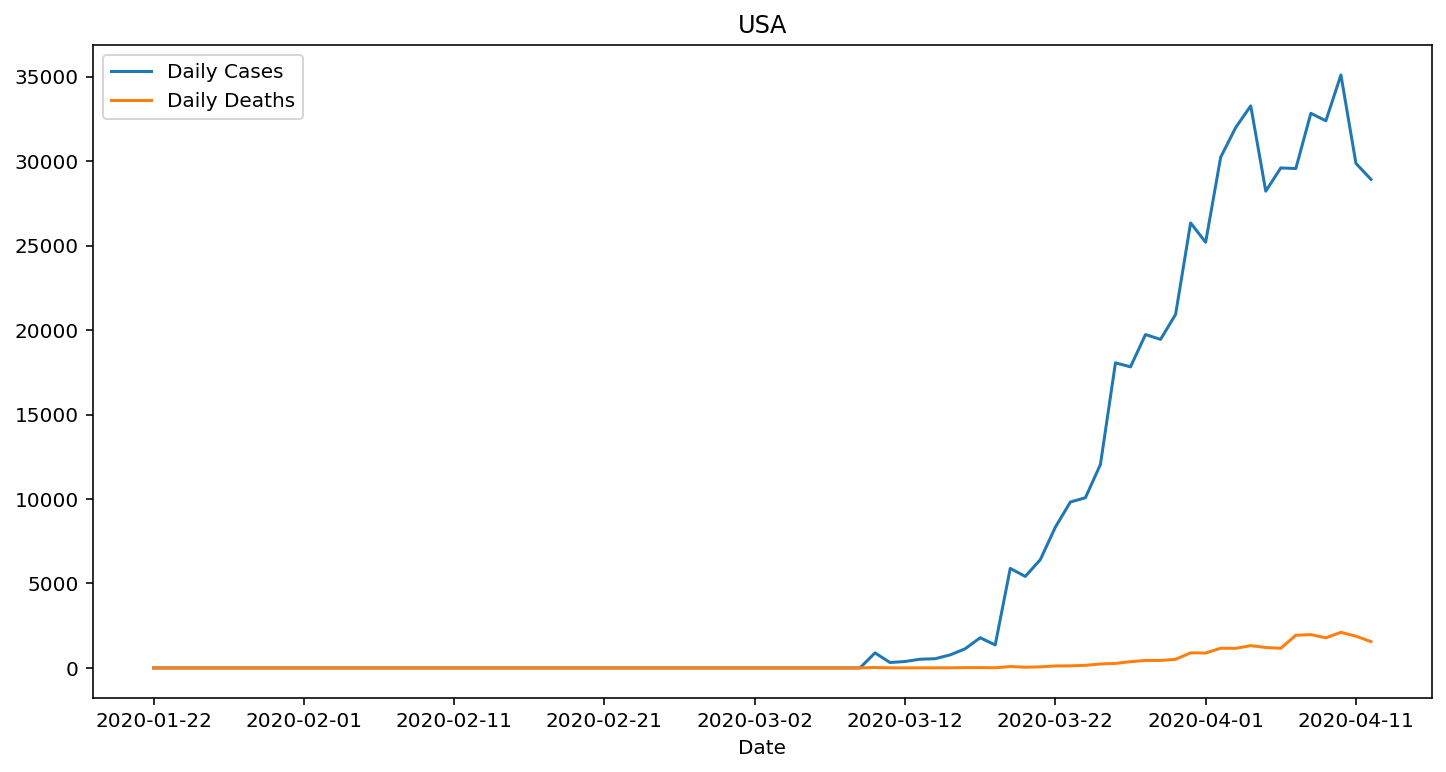

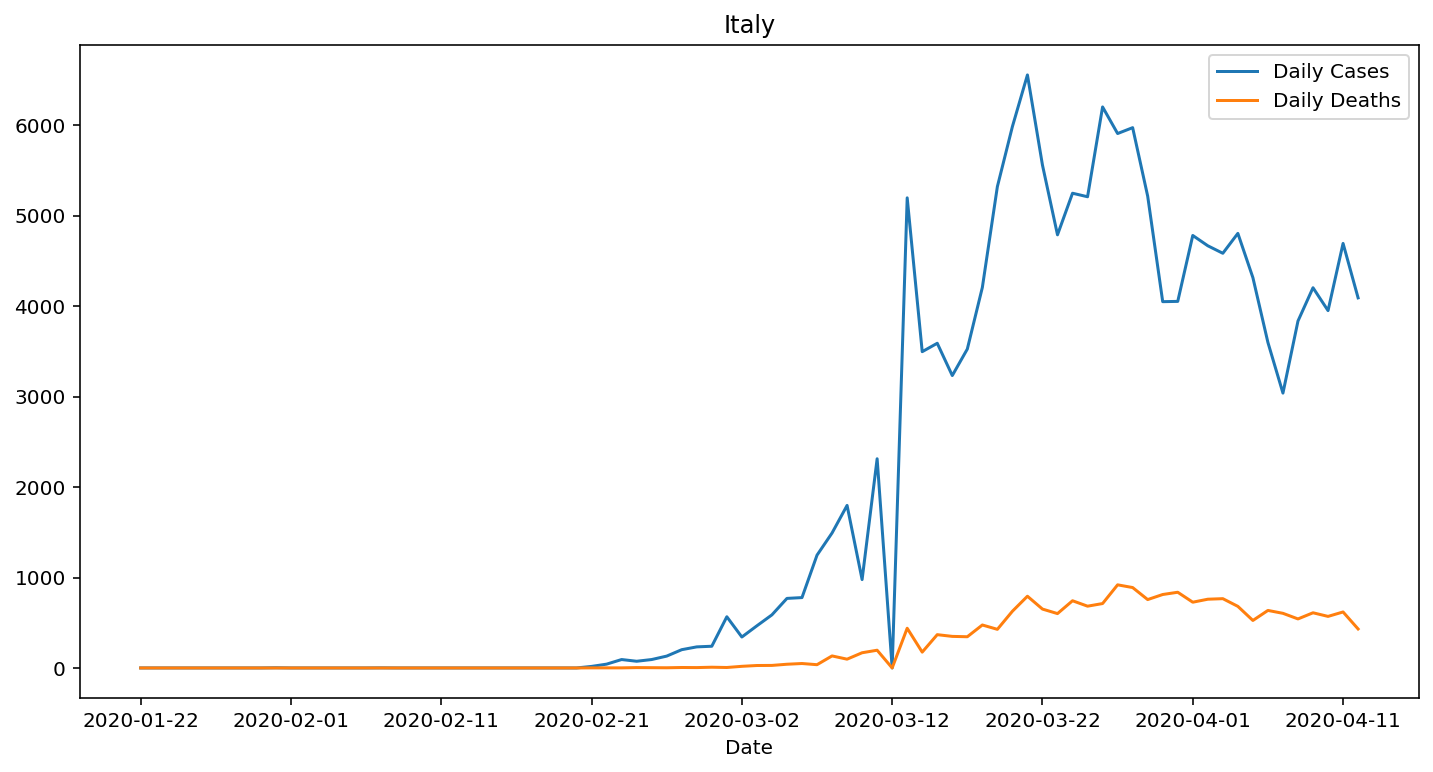

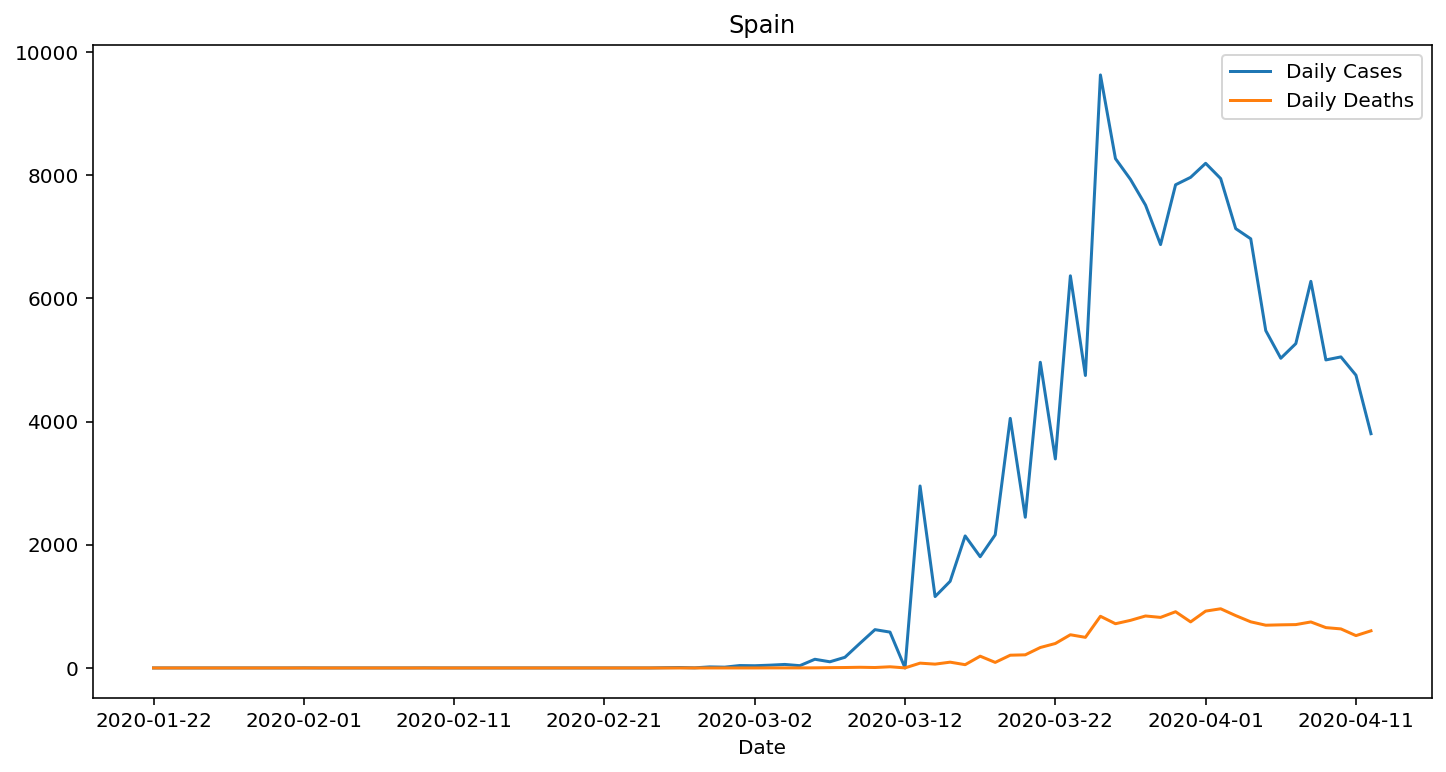

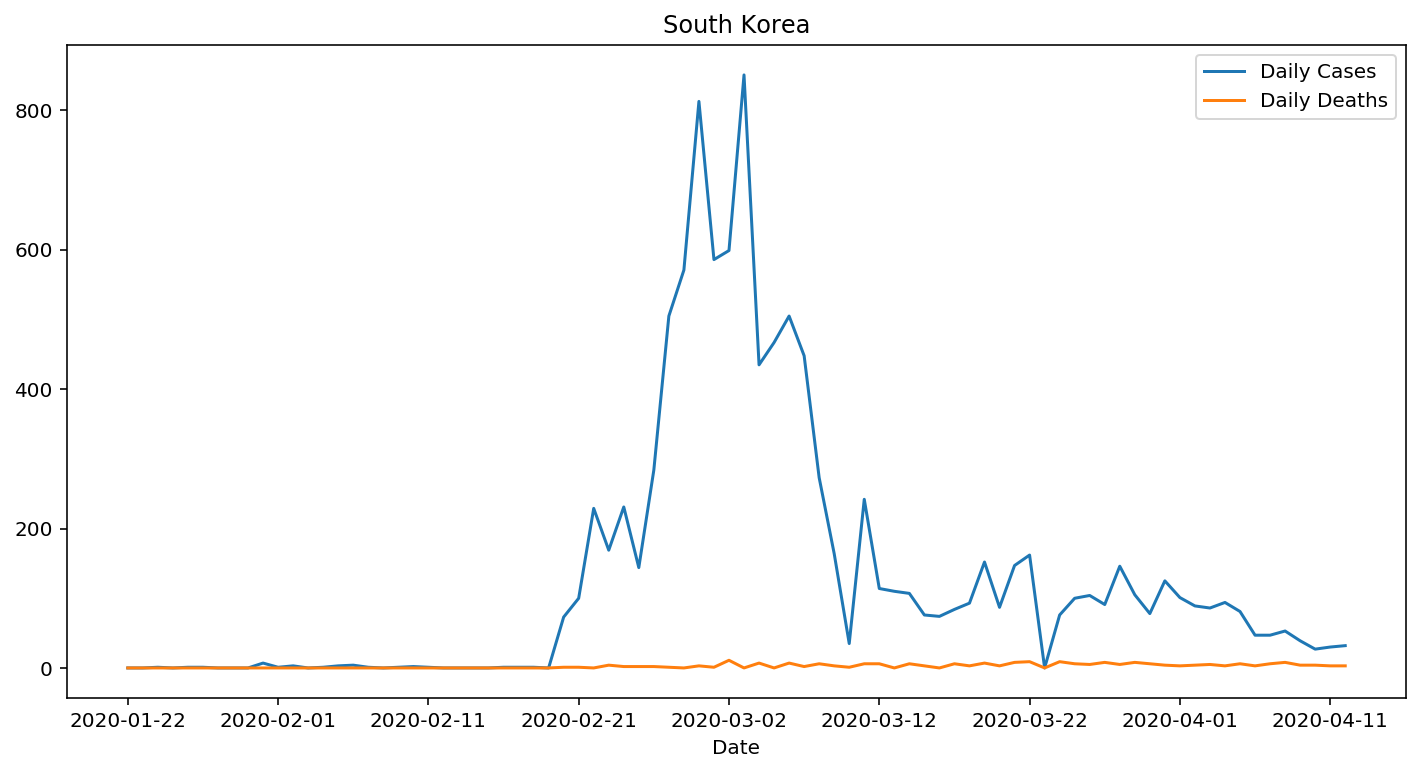

In [8]:
# USA
df_usa = data_train.query("Country_Region=='US'")
df_usa = df_usa.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_usa = add_daily_measures(df_usa)

#Italy
df_italy = data_train.query("Country_Region=='Italy'")
df_italy = df_italy.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_italy = add_daily_measures(df_italy)

#Spain
df_spain = data_train.query("Country_Region=='Spain'")
df_spain = df_spain.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_spain = add_daily_measures(df_spain)

#Korea
df_korea = data_train.query("Country_Region=='Korea, South'")
df_korea = df_korea.groupby('Date',as_index=False)['ConfirmedCases','Fatalities'].sum()
df_korea = add_daily_measures(df_korea)


df_usa.plot(title = "USA", y=['Daily Cases','Daily Deaths'], x='Date', figsize=(12,6))

df_italy.plot(title = "Italy", y=['Daily Cases','Daily Deaths'], x='Date', figsize=(12,6))

df_spain.plot(title = "Spain", y=['Daily Cases','Daily Deaths'], x='Date', figsize=(12,6))

df_korea.plot(title = "South Korea", y=['Daily Cases','Daily Deaths'], x='Date', figsize=(12,6))

## Flight information for countries

Reference : https://www.radarbox.com/statistics/total

In [9]:
data_flight = pd.read_csv('covid19_flight_countries_mod.csv')

data_flight.head()

,Date,Total Commercial,US <-> US,US <-> NON US,US <-> Europe,US <-> Latin America,US <-> Asia,US <-> China,Canada <-> Canada,Canada <-> NON Canada,...,Italy <-> Italy,Italy <-> NON Italy,China <-> China,China <-> NON China,Brazil <-> Brazil,Brazil <-> NON Brazil,India <-> India,India <-> NON India,Iran <-> Iran,Iran <-> NON Iran
0,2019-12-31,94679,24916,5271,707,2576,680,134,2419,1599,...,509,1876,10159,2694,1949,396,2797,1176,114,208
1,2020-01-01,90778,20701,5098,739,2500,667,131,1988,1551,...,519,1953,10123,2832,1649,374,2899,1226,115,195
2,2020-01-02,104745,25659,5783,850,2826,731,140,2564,1723,...,671,2324,10312,2759,2216,432,2930,1192,99,204
3,2020-01-03,108042,27206,6060,866,2982,718,139,2618,1846,...,677,2379,10386,2932,2237,466,2942,1261,123,196
4,2020-01-04,100756,24584,6335,870,3380,751,152,2009,1861,...,594,2198,10370,2802,2035,473,2881,1239,118,189


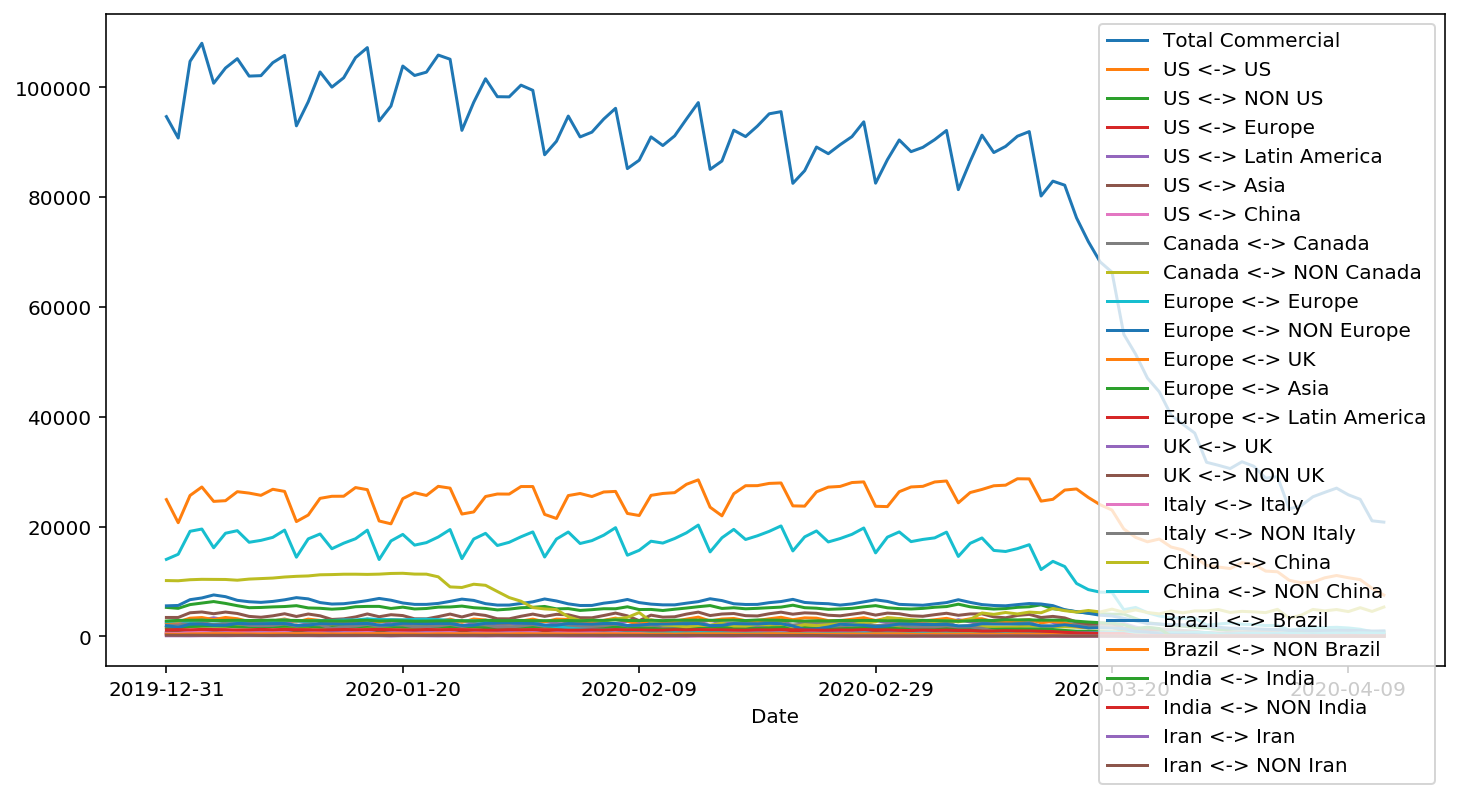

In [10]:
data_flight.plot(x='Date', figsize=(12,6))

## Testd value per day

Reference : https://ourworldindata.org/grapher/full-list-covid-19-tests-per-day

In [11]:
#full-list-covid-19-tests-per-day
data_daily_tested = pd.read_csv('full-list-covid-19-tests-per-day.csv')

data_daily_tested.head()

,Entity,Code,Date,Daily change in cumulative total tests
0,Argentina,ARG,2020-04-09,1520
1,Argentina,ARG,2020-04-10,1529
2,Argentina,ARG,2020-04-11,1648
3,Australia,AUS,2020-04-03,16278
4,Australia,AUS,2020-04-07,8038


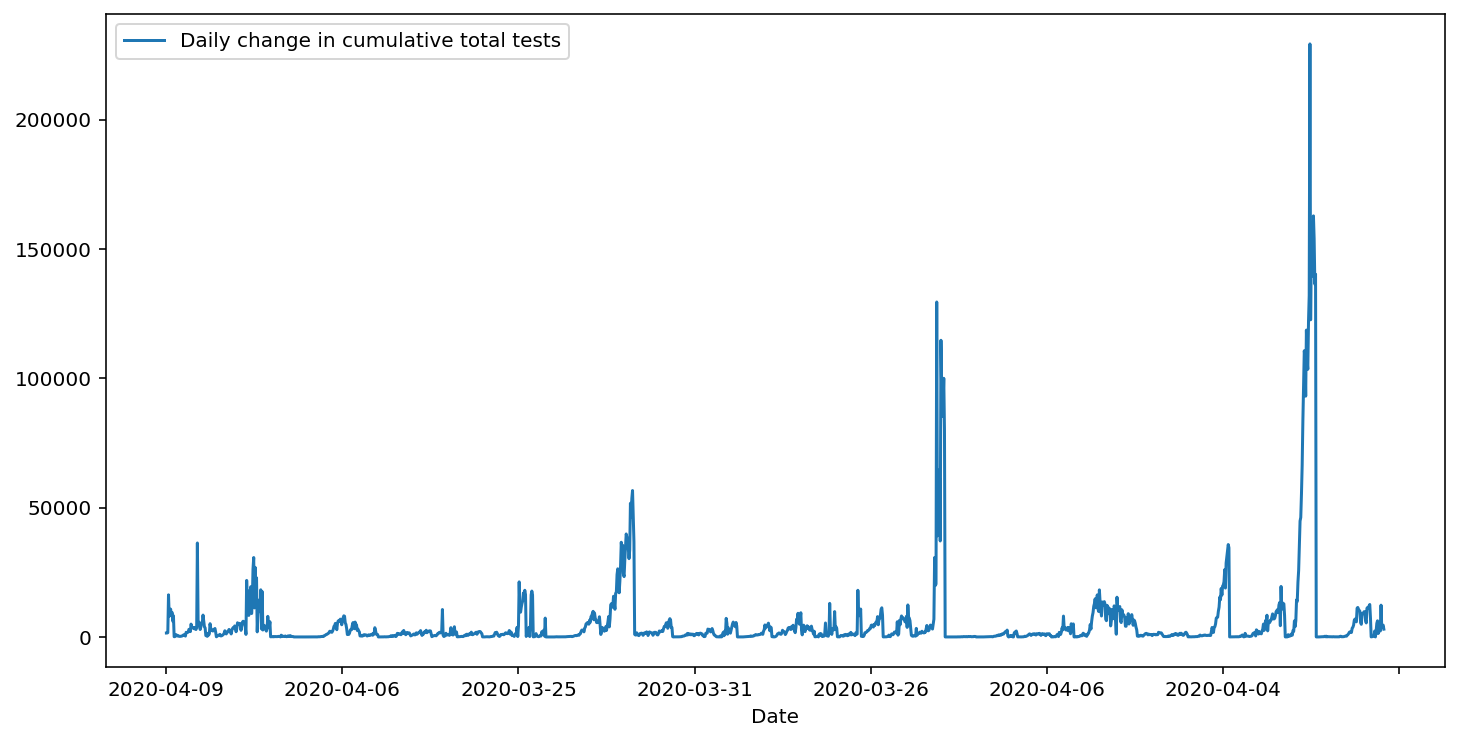

In [12]:
data_daily_tested.plot(x='Date', figsize=(12,6))

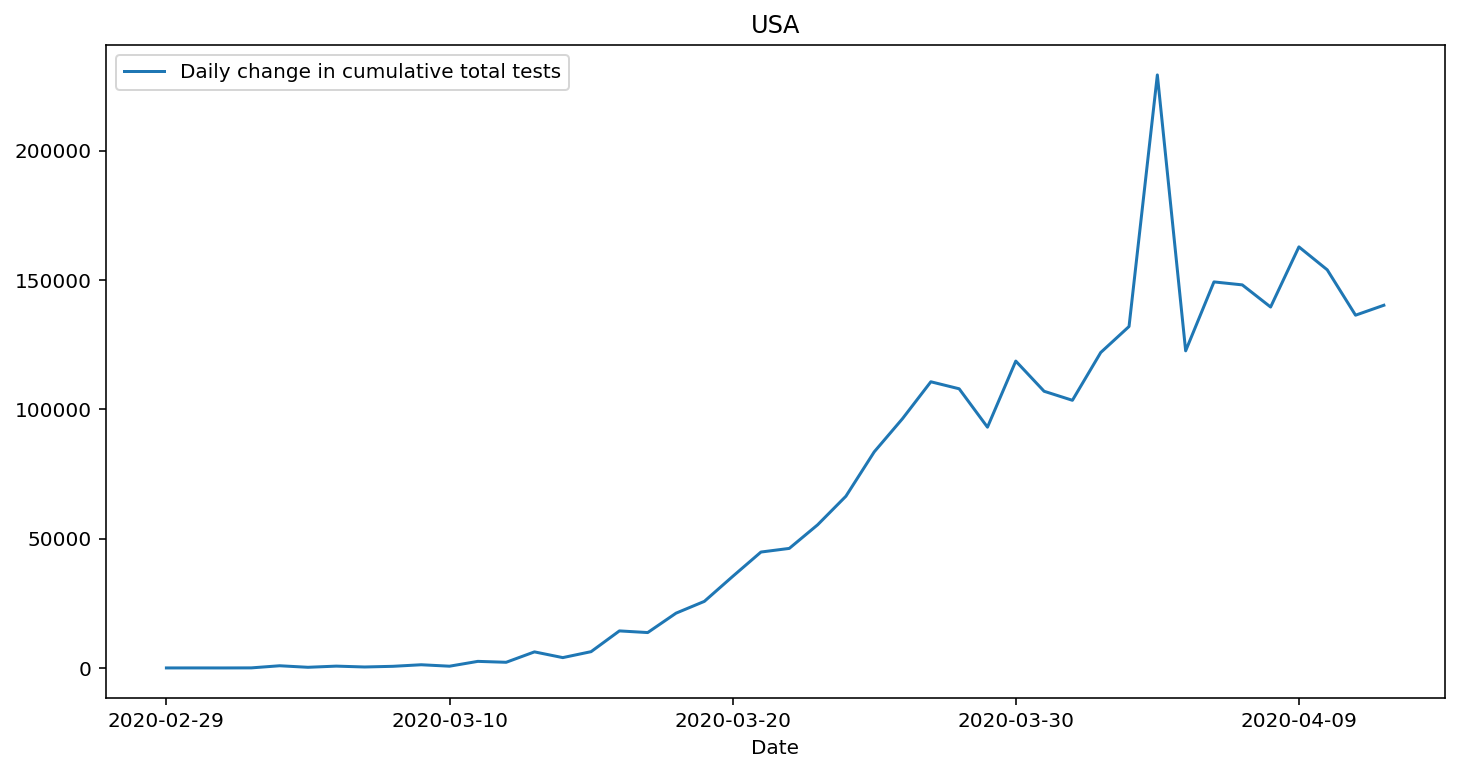

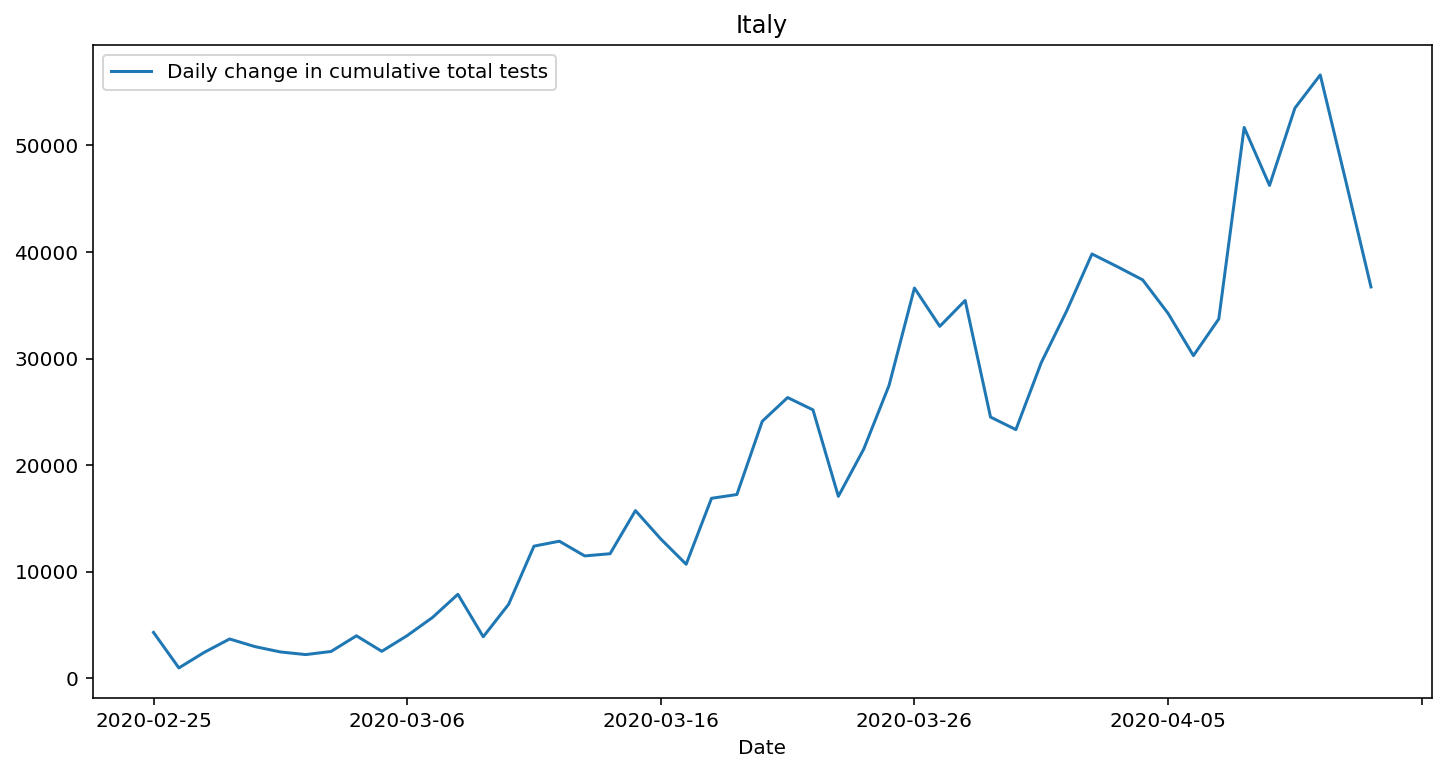

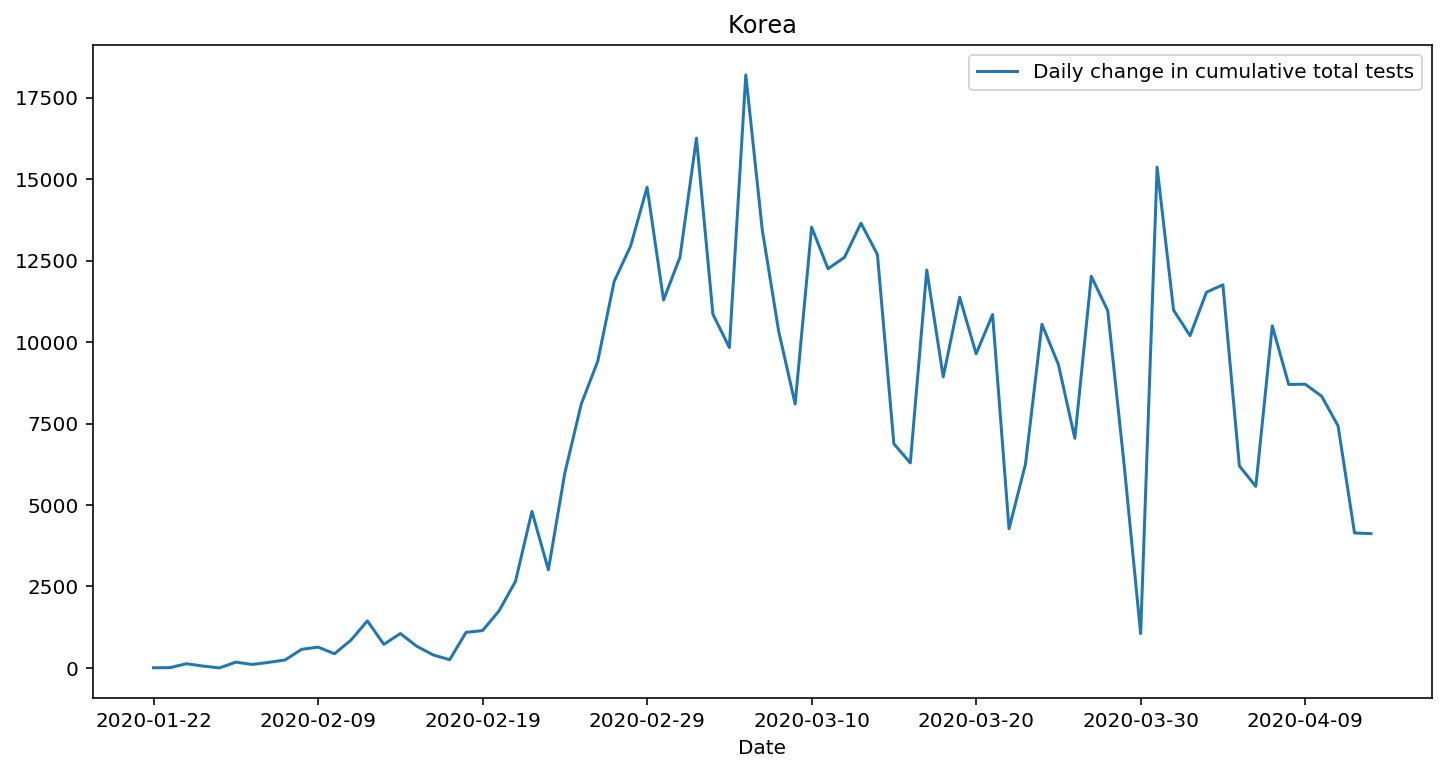

In [13]:
df_usa_tested = data_daily_tested.query("Code=='USA'")
df_italy_tested = data_daily_tested.query("Entity=='Italy'")
df_spain_tested = data_daily_tested.query("Entity=='Spain'")
df_korea_tested = data_daily_tested.query("Entity=='South Korea'")
#df_usa_tested.head()
#df_italy_tested.head()
#df_spain_tested.head()
#df_korea_tested.head()
df_usa_tested.plot(title='USA', x='Date', figsize=(12,6))
df_italy_tested.plot(title='Italy', x='Date', figsize=(12,6))
df_korea_tested.plot(title='Korea', x='Date', figsize=(12,6))


In [14]:
df_usa_merge = pd.merge(df_usa, df_usa_tested)
df_usa_merge = pd.merge(df_usa_merge, data_flight)
df_usa_merge.head()
#df_usa_merge.plot()


,Date,ConfirmedCases,Fatalities,Daily Cases,Daily Deaths,Entity,Code,Daily change in cumulative total tests,Total Commercial,US <-> US,...,Italy <-> Italy,Italy <-> NON Italy,China <-> China,China <-> NON China,Brazil <-> Brazil,Brazil <-> NON Brazil,India <-> India,India <-> NON India,Iran <-> Iran,Iran <-> NON Iran
0,2020-02-29,0.0,0.0,0.0,0.0,United States,USA,9,82554,23690,...,406,1960,2637,539,1761,466,2868,1180,72,70
1,2020-03-01,0.0,0.0,0.0,0.0,United States,USA,13,86833,23634,...,478,2083,3385,601,1913,465,2832,1171,77,65
2,2020-03-02,0.0,0.0,0.0,0.0,United States,USA,4,90425,26346,...,501,2053,3222,534,2254,462,2859,1096,62,62
3,2020-03-03,0.0,0.0,0.0,0.0,United States,USA,31,88294,27214,...,445,1730,3053,539,2212,411,2775,1062,69,46
4,2020-03-04,0.0,0.0,0.0,0.0,United States,USA,850,89081,27325,...,458,1692,2893,589,2157,384,2913,1129,71,64


In [15]:
#USA considering case
#df_usa_data = df_usa_merge.drop(['Date', 'Entity', 'Code', 'Total Commercial', 'US <-> Latin America', 'US <-> Asia', 'US <-> China', 'Canada <-> Canada', 'Canada <-> NON Canada', 'Europe <-> Europe', 'Europe <-> NON Europe', 'Europe <-> UK', 'Europe <-> Asia', 'Europe <-> Latin America', 'UK <-> UK', 'UK <-> NON UK', 'Italy <-> Italy', 'Italy <-> NON Italy', 'China <-> China', 'China <-> NON China', 'Brazil <-> Brazil', 'Brazil <-> NON Brazil', 'India <-> India', 'India <-> NON India', 'Iran <-> Iran', 'Iran <-> NON Iran'], axis=1)
df_usa_data = df_usa_merge.drop(['Date', 'Entity', 'Code', 'US <-> Latin America', 'US <-> China', 'Canada <-> Canada', 'Canada <-> NON Canada', 'Europe <-> Europe', 'Europe <-> UK', 'Europe <-> Latin America', 'UK <-> UK', 'UK <-> NON UK', 'Italy <-> Italy', 'China <-> China', 'Brazil <-> Brazil', 'Brazil <-> NON Brazil', 'India <-> India', 'India <-> NON India', 'Iran <-> Iran'], axis=1)
df_usa_data.head()

,ConfirmedCases,Fatalities,Daily Cases,Daily Deaths,Daily change in cumulative total tests,Total Commercial,US <-> US,US <-> NON US,US <-> Europe,US <-> Asia,Europe <-> NON Europe,Europe <-> Asia,Italy <-> NON Italy,China <-> NON China,Iran <-> NON Iran
0,0.0,0.0,0.0,0.0,9,82554,23690,5593,871,561,6649,1589,1960,539,70
1,0.0,0.0,0.0,0.0,13,86833,23634,5199,899,528,6359,1530,2083,601,65
2,0.0,0.0,0.0,0.0,4,90425,26346,5049,864,512,5825,1375,2053,534,62
3,0.0,0.0,0.0,0.0,31,88294,27214,4981,812,498,5739,1376,1730,539,46
4,0.0,0.0,0.0,0.0,850,89081,27325,5091,842,510,5664,1427,1692,589,64


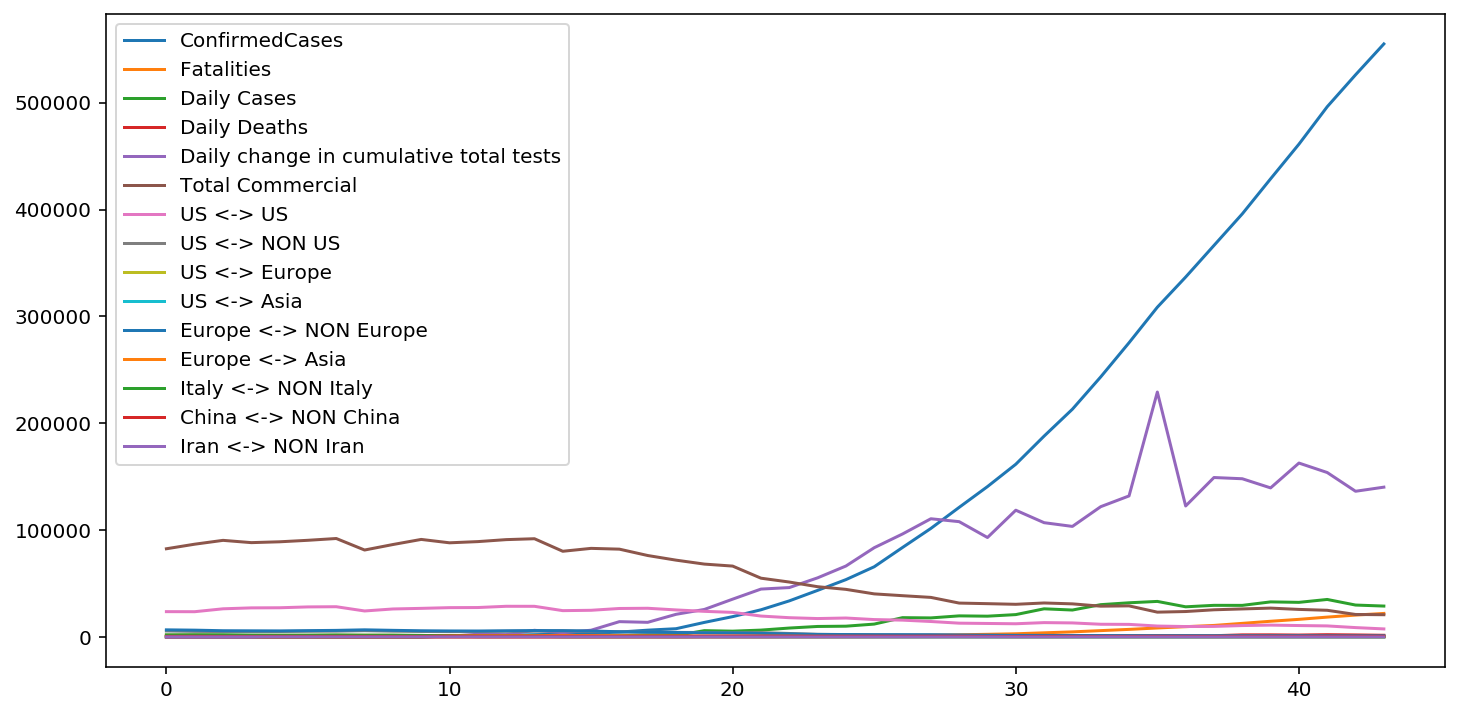

In [16]:
df_usa_data.plot(figsize=(12,6))

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [17]:
quant_features = ['Daily Cases', 'Daily change in cumulative total tests', 'US <-> US', 'US <-> NON US','US <-> Europe', 'ConfirmedCases']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = df_usa_data[each].mean(), df_usa_data[each].std()
    scaled_features[each] = [mean, std]
    df_usa_data.loc[:, each] = (df_usa_data[each] - mean)/std

df_usa_data.head()    

,ConfirmedCases,Fatalities,Daily Cases,Daily Deaths,Daily change in cumulative total tests,Total Commercial,US <-> US,US <-> NON US,US <-> Europe,US <-> Asia,Europe <-> NON Europe,Europe <-> Asia,Italy <-> NON Italy,China <-> NON China,Iran <-> NON Iran
0,-0.744463,0.0,-0.963453,0.0,-1.006300,82554,0.620267,1.253453,1.345303,561,6649,1589,1960,539,70
1,-0.744463,0.0,-0.963453,0.0,-1.006237,86833,0.612502,1.045601,1.439155,528,6359,1530,2083,601,65
2,-0.744463,0.0,-0.963453,0.0,-1.006379,90425,0.988531,0.966470,1.321840,512,5825,1375,2053,534,62
3,-0.744463,0.0,-0.963453,0.0,-1.005952,88294,1.108882,0.930597,1.147545,498,5739,1376,1730,539,46
4,-0.744463,0.0,-0.963453,0.0,-0.993027,89081,1.124273,0.988627,1.248100,510,5664,1427,1692,589,64


### Splitting the data into training, testing, and validation sets



In [18]:
# Save data for approximately the last 21 days 
test_data = df_usa_data[-15:]

# Now remove the test data from the data set 
data = df_usa_data[:-15]

# Separate the data into features and targets
target_fields = ['Daily Cases', 'Daily change in cumulative total tests', 'ConfirmedCases']
features, targets = df_usa_data.drop(target_fields, axis=1), df_usa_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
#train_features_cnn, train_targets_cnn = features, targets

Will split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [19]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-43], targets[:-43]
val_features, val_targets = features[-43:], targets[-43:]

#for mlnn
train_features_mlp, train_targets_mlp = train_features, train_targets
test_features_mlp, test_targets_mlp = test_features, test_targets
val_features_mlp, val_targets_mlp = features[-43:], targets[-43:]

#for cnn
train_features_cnn, train_targets_cnn = train_features, train_targets
test_features_cnn, test_targets_cnn = test_features, test_targets

## * Try to apply different NN way

## A. Build the network



In [20]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # Sigmoid activation function
        self.activation_function = lambda x : (1/(1+np.exp(-x)))  
                    
    def train(self, features, targets):
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X) 
            
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):

        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        
        error = y-final_outputs # Output layer error is the difference between desired target and actual output.
        
        # The hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        
        #Backpropagated error terms
        output_error_term = error * 1
        
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:,None]
        # Weight step (hidden to output)
        delta_weights_h_o += (output_error_term * hidden_outputs[:,None])
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        
        # update hidden-to-output weights with gradient descent step
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_records 

        # update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_records 

    def run(self, features):
        
        #Hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        #Output layer 
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs


In [21]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## A-1. Hyper parameters

iterations, learning rate, hidden nodes, output nodes

In [37]:
#Hyperparameter

iterations = 400
learning_rate = 0.0001
hidden_nodes = 20
output_nodes = 1

## A-2. Training

In [38]:
import sys

N_i = train_features.shape[1]
print(N_i)
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['Daily Cases']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['Daily Cases'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['Daily Cases'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

12
Progress: 5.5% ... Training loss: 1.458 ... Validation loss: 0.864

C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Progress: 99.8% ... Training loss: 0.546 ... Validation loss: 0.754

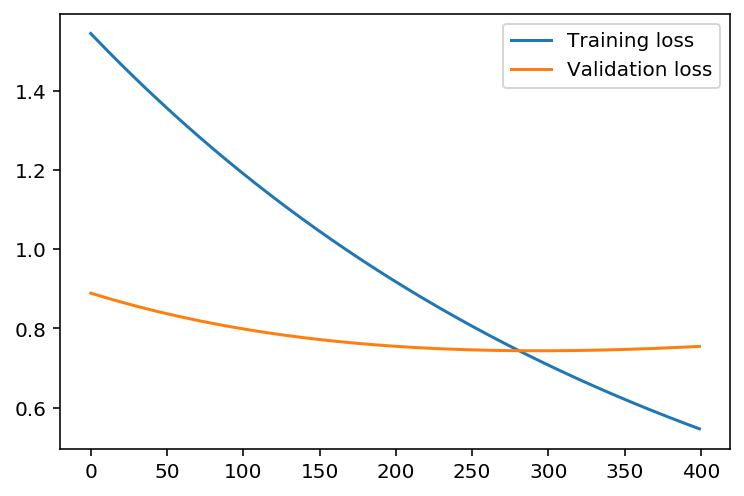

In [39]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## A-3. Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

C:\Users\CHANGKUNWOO\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


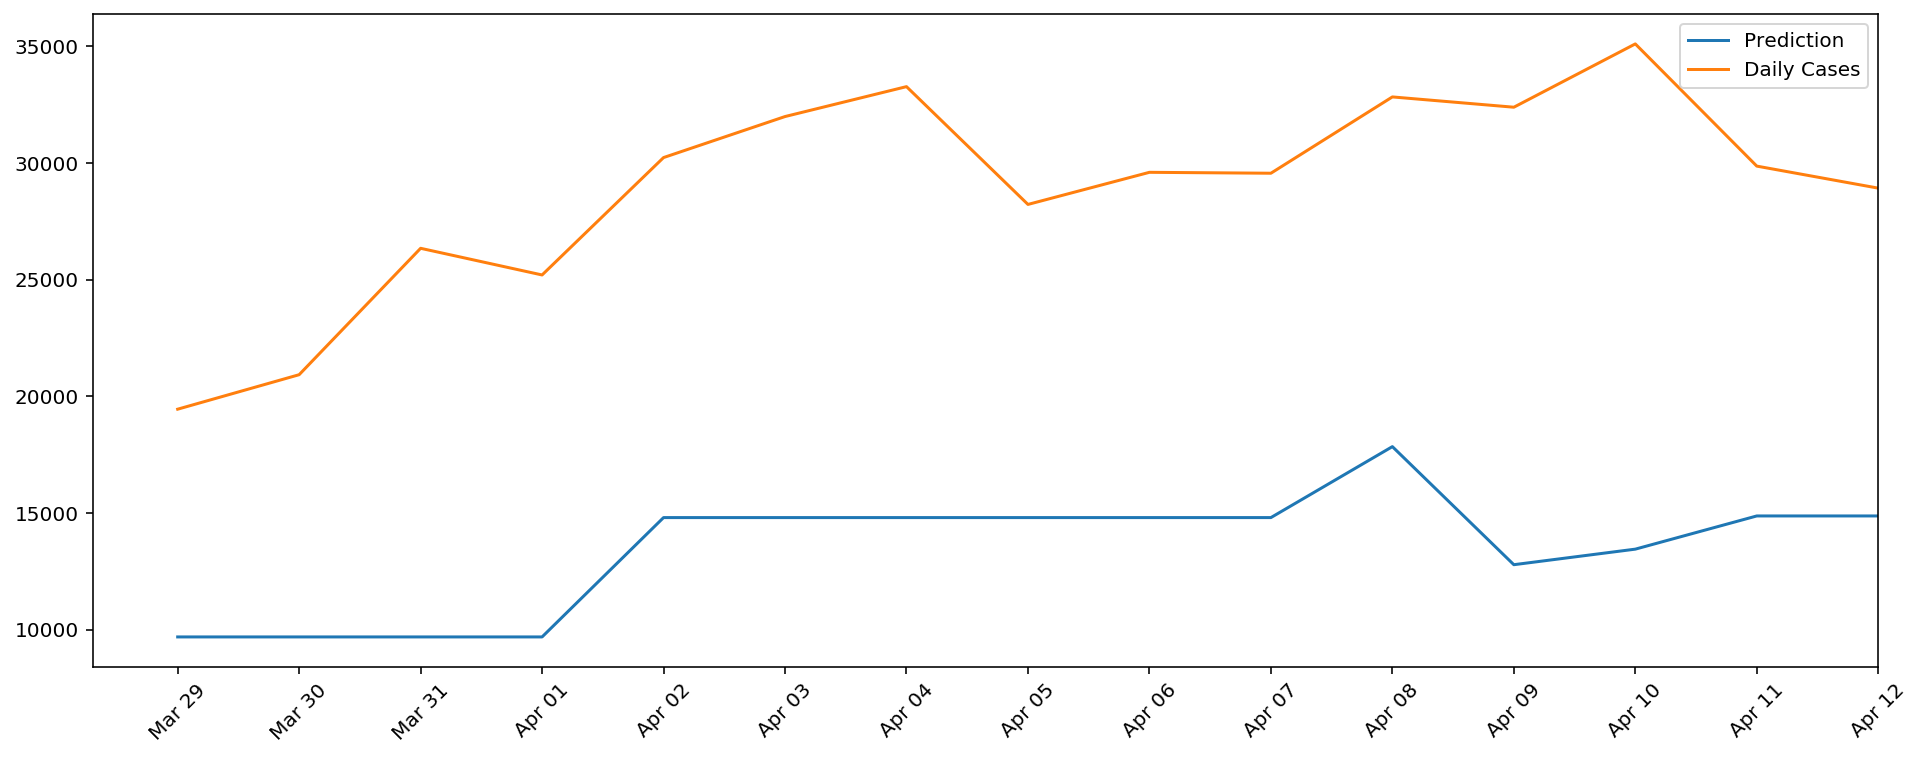

In [40]:
fig, ax = plt.subplots(figsize=(16,6))

mean, std = scaled_features['Daily Cases']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['Daily Cases']*std + mean).values, label='Daily Cases')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df_usa_merge.iloc[test_data.index]['Date'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates)))
_ = ax.set_xticklabels(dates, rotation=45)

## B. multilayer perceptron model(MLP) with pytorch


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

## B.1 Multi-layer model

In [27]:
class MLPModel(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        ## Define layers of a Multi layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        ## Define forward behavior
        out = self.layer1(x)
        #out = nn.ReLU(out)
        out = self.layer2(out)
        out = self.sigmoid(out)
        
        return out

## B.2 Data set

In [28]:
featuresTrain_mlp = torch.Tensor(train_features_mlp.values).type(torch.FloatTensor)
targetsTrain_mlp = torch.Tensor(train_targets_mlp.values).type(torch.FloatTensor)#torch.LongTensor) 

# Create feature and targets tensor for test set.
#test_features_cnn, test_targets_cnn
featuresTest_mlp = torch.from_numpy(test_features_mlp.values).type(torch.FloatTensor)
targetsTest_mlp = torch.from_numpy(test_targets_mlp.values).type(torch.FloatTensor)#LongTensor) 



batch_size = 50
train_mlp = torch.utils.data.TensorDataset(featuresTrain_mlp, targetsTrain_mlp)#(featuresTrain, targetsTrain)
train_loader_mlp = torch.utils.data.DataLoader(train_mlp, 
                                            batch_size = batch_size, 
                                            shuffle = False)

#val_features_mlp, val_targets_mlp

## B.3 Train

In [32]:
input_mlp = 12
hidden_mlp = 10
output_mlp = 1
learning_mlp = 0.001
model_mlp = MLPModel(input_mlp, hidden_mlp, output_mlp)
#model_mlp.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), learning_mlp )

#for input
for epoch in range(1, 101): ## run the model for 10 epochs
    train_loss, valid_loss = [], []
    ## training part 
    model_mlp.train()
    for data, target in train_loader_mlp:
        optimizer.zero_grad()
        ## 1. forward propagation
        output = model_mlp(data)
        
        ## 2. loss calculation
        #loss = loss.reshape(-1)
        loss = criterion(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    ## evaluation part 
    #model_mlp.eval()
    #for data, target in validloader:
    #    output = model_mlp(data)
    #    loss = loss_function(output, target)
    #    valid_loss.append(loss.item())
    
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss))#, "Valid Loss: ", np.mean(valid_loss))

Epoch: 1 Training Loss:  0.8317019939422607
Epoch: 2 Training Loss:  0.8317019939422607
Epoch: 3 Training Loss:  0.8317019939422607
Epoch: 4 Training Loss:  0.8317019939422607
Epoch: 5 Training Loss:  0.8317019939422607
Epoch: 6 Training Loss:  0.8317019939422607
Epoch: 7 Training Loss:  0.8317019939422607
Epoch: 8 Training Loss:  0.8317019939422607
Epoch: 9 Training Loss:  0.8317019939422607
Epoch: 10 Training Loss:  0.8317019939422607
Epoch: 11 Training Loss:  0.8317019939422607
Epoch: 12 Training Loss:  0.8317019939422607
Epoch: 13 Training Loss:  0.8317019939422607
Epoch: 14 Training Loss:  0.8317019939422607
Epoch: 15 Training Loss:  0.8317019939422607
Epoch: 16 Training Loss:  0.8317019939422607
Epoch: 17 Training Loss:  0.8317019939422607
Epoch: 18 Training Loss:  0.8317019939422607
Epoch: 19 Training Loss:  0.8317019939422607
Epoch: 20 Training Loss:  0.8317019939422607
Epoch: 21 Training Loss:  0.8317019939422607
Epoch: 22 Training Loss:  0.8317019939422607
Epoch: 23 Training 

## C. CNN 

## C.1 CNN model

In [ ]:
class CNNModel(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(CNNModel, self).__init__()
        ## Define layers of a CNN
        # convolutional layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 2), padding=1)
        # convolutional layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), padding=1)
        # convolutional layer 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 2), padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))
        # linear layer
        self.fc1 = nn.Linear(64*7, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 2)
        self.dropout = nn.Dropout(0.25)#0.5
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = self.bn3(self.pool(F.relu(self.conv3(x))))
        #flatten
        x = x.view(x.size(0), -1)
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x

## C.2 data set

In [ ]:
# Create feature and targets tensor for train set. 
##featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
##targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) 
featuresTrain = torch.Tensor(train_features_cnn.values).type(torch.FloatTensor)
targetsTrain = torch.Tensor(train_targets_cnn.values).type(torch.LongTensor) 

# Create feature and targets tensor for test set.
#test_features_cnn, test_targets_cnn
featuresTest = torch.from_numpy(test_features_cnn.values).type(torch.FloatTensor)
targetsTest = torch.from_numpy(test_targets_cnn.values).type(torch.LongTensor) 


batch_size = 50
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)#(featuresTrain, targetsTrain)
train_loader = torch.utils.data.DataLoader(train, 
                                            batch_size = batch_size, 
                                            shuffle = False)
#print(images)

## C.3 Train

In [ ]:
model = CNNModel()
error = nn.CrossEntropyLoss()
learning_rate = 0.013
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
num_epochs = 100
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        model.train()
        train = images#.reshape(images.shape[0],1,1, 7)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)       
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
    
    # Iterate through test dataset
    model.eval()
    test = featuresTest#.reshape(featuresTest.shape[0],1,1, 7)
    # Forward propagation
    outputs = model(test)
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    # Total number of labels
    total = len(targetsTest)
    correct = (predicted == targetsTest).sum()
    accuracy = 100 * correct / float(total)

    # store loss and iteration
    loss_list.append(loss.item()*100)
    iteration_list.append(epoch)
    accuracy_list.append(accuracy)
           
    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(epoch, loss.item(), accuracy))

###############Start predictation#####################
model.eval()
test = torch.from_numpy(test_df.values).type(torch.FloatTensor)
outest = model(test.reshape(-1, 1, 1, 7))

_, predicted = torch.max(outest.data, 1)
idx = np.arange(start= 892, stop= 892 +test.shape[0])
df2 = pd.DataFrame({'Passenger': idx, 
                    'Survived': predicted})
df2.to_csv('./jrxie.csv', index= False)
print ("Finish!!")